
# Interpretable Decision Tree for Hypothesis Generation

Optimized for severely imbalanced data with explicit decision rules  
Uses repeated stratified holdout for robust evaluation

## Statistical validity of repeated holdout

Repeated stratified holdout is scientifically rigorous and often superior
to k-fold CV for severely imbalanced data:

1. Provides unbiased performance estimates (Kohavi, 1995)
2. Better variance-bias tradeoff with small samples (Arlot & Celisse, 2010)
3. Ensures adequate minority class representation in each test set
4. Standard practice in imbalanced learning literature

References:
- Kohavi, R. (1995). "A study of cross-validation and bootstrap for accuracy estimation"
- Bischl, B. et al. (2012). "Resampling strategies for imbalanced data"
- López, V. et al. (2013). "An insight into classification with imbalanced data"

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from collections import defaultdict

# Data loading and preprocessing


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
import os
if not os.path.ismount("/content/drive"):
    drive.mount('/content/drive')

BASE_PATH = "/content/drive/MyDrive/Stice/AtyAN"
DATA_FILE = BASE_PATH + "/BP1234-ONSET.csv"

# Load data
df = pd.read_csv(DATA_FILE, low_memory=False)
print(f"Loaded {len(df)} participants")

# Create prodromal features
df["BE_w1"] = pd.to_numeric(df.get("w1ede1a"), errors="coerce")

cb_cols = ["w1ed8a", "w1ed9a", "w1ed10a", "w1ed11a"]
cb_cols = [c for c in cb_cols if c in df.columns]
if cb_cols:
    cb_mat = df[cb_cols].apply(pd.to_numeric, errors="coerce")
    df["CB_w1"] = cb_mat.max(axis=1, skipna=True)
    df.loc[cb_mat.notna().sum(axis=1) == 0, "CB_w1"] = np.nan

df["WSO_w1"] = pd.to_numeric(df.get("w1ed15a"), errors="coerce")
df["FEAR_w1"] = pd.to_numeric(df.get("w1ed17a"), errors="coerce")
df["FAT_w1"] = pd.to_numeric(df.get("w1ed19a"), errors="coerce")

mbmi_pct = pd.to_numeric(df.get("w1mbmi_pct"), errors="coerce")
df["LEB_w1"] = np.clip(90.0 - mbmi_pct, 0, None) / 90.0




Loaded 1952 participants


1. All risk factors and prodromal symptoms
2. Only statistically significant risk factors and prodromal symptoms
3. Only statistically significant AND Cohen's d > 0.5

In [ ]:
EXPERIMENT_VAR = 2
# Risk factors
RISK_FACTORS = {
     1: ["w1tii", "w1bs", "w1dres", "w1socf", "w1dep", "w1intbmi"],
     2: ["w1tii", "w1bs", "w1dres", "w1socf", "w1dep"],
     3: ["w1bs", "w1dres", "w1dep"]
  }
PRODROMALS = {
     1: ["BE_w1", "CB_w1", "WSO_w1", "FEAR_w1", "FAT_w1", "LEB_w1"],
     2: ["CB_w1", "WSO_w1", "FEAR_w1", "FAT_w1"],
     3: ["CB_w1", "WSO_w1", "FEAR_w1", "FAT_w1"]  # same as 2
  }

FEATURES = RISK_FACTORS[EXPERIMENT_VAR] + PRODROMALS[EXPERIMENT_VAR]

# Prepare X and y
X = df[FEATURES].copy()
y = df["w1ONSET-FULL"].apply(pd.to_numeric, errors="coerce").fillna(0).astype(int)

valid_rows = X.notna().any(axis=1) & y.notna()
X = X[valid_rows]
y = y[valid_rows]

print(f"Dataset: {len(X)} participants, {y.sum()} positive cases ({y.mean()*100:.1f}%)")

Dataset: 1952 participants, 34 positive cases (1.7%)


In [ ]:
FEATURES

['w1tii',
 'w1bs',
 'w1dres',
 'w1socf',
 'w1dep',
 'CB_w1',
 'WSO_w1',
 'FEAR_w1',
 'FAT_w1']

# Tree configuration

I have two decision trees, as it's a relatively weaker model. I'd normally use the cost-complexity pruning (penalizes the model for having too many leaves) for overfitting, but it may lead to underfitting.

In [ ]:
def create_decision_tree(strategy='pruned'):
    """Create optimized decision tree"""

    if strategy == 'simple':
        return DecisionTreeClassifier(
            max_depth=4,              # Shallow for interpretability
            min_samples_leaf=20,      # Higher to prevent overfitting
            min_samples_split=40,     # Require substantial splits
            max_features=None,        # May overfit slightly but maximizes performance
            class_weight='balanced',
            random_state=42
        )

    elif strategy == 'pruned':
        return DecisionTreeClassifier(
            max_depth=6,              # Initially deeper
            min_samples_leaf=15,
            min_samples_split=30,
            class_weight='balanced',
            ccp_alpha=0.01,           # Pruning
            random_state=42
        )

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, average_precision_score, roc_auc_score
)

# You supply this factory:
# def create_decision_tree(strategy: str) -> DecisionTreeClassifier: ...

def _summarize_distribution(s):
    return {
        "mean": float(s.mean()),
        "sd": float(s.std(ddof=1)),
        "median": float(s.median()),
        "q25": float(s.quantile(0.25)),
        "q75": float(s.quantile(0.75)),
    }

def repeated_holdout_oof_dt(
    X, y, *,
    n_repeats=500,
    test_size=0.3,
    strategy='pruned',
    threshold=0.5,
    random_state=42
):
    """
    Repeated stratified holdout with OOF aggregation.
    Returns:
      per_split_df: per-repeat metrics (for distribution summaries)
      oof_summary: pooled OOF metrics + distribution summaries
      final_pipeline: pipeline refit on full data (for downstream use)
    """

    sss = StratifiedShuffleSplit(
        n_splits=n_repeats, test_size=test_size, random_state=random_state
    )

    # Accumulate test-time probabilities per sample
    oof_lists = [[] for _ in range(len(y))]

    per_split = []
    for split_i, (tr_idx, te_idx) in enumerate(sss.split(X, y), start=1):
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('clf', create_decision_tree(strategy))
        ])

        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        pipeline.fit(X_tr, y_tr)

        y_proba = pipeline.predict_proba(X_te)[:, 1]
        y_pred  = (y_proba >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_te, y_pred, labels=[0,1]).ravel()

        pr_auc  = average_precision_score(y_te, y_proba)
        roc_auc = roc_auc_score(y_te, y_proba)

        ppv  = tp / (tp + fp) if (tp + fp) else 0.0
        npv  = tn / (tn + fn) if (tn + fn) else 0.0
        sens = tp / (tp + fn) if (tp + fn) else 0.0
        spec = tn / (tn + fp) if (tn + fp) else 0.0
        acc  = (tp + tn) / (tp + tn + fp + fn)

        per_split.append({
            "iteration": split_i,
            "pr_auc": pr_auc,
            "roc_auc": roc_auc,
            "accuracy": acc,
            "ppv": ppv,
            "npv": npv,
            "sensitivity": sens,
            "specificity": spec,
            "tp": tp, "fp": fp, "tn": tn, "fn": fn,
            "n_test_pos": int(y_te.sum()),
            "n_test": int(len(y_te))
        })

        # store OOF (test-time) probabilities for those indices
        for j, idx in enumerate(te_idx):
            oof_lists[idx].append(y_proba[j])

    per_split_df = pd.DataFrame(per_split)

    # Collapse to one OOF score per sample (mean of its test-time scores)
    oof_scores = np.array([np.mean(v) if len(v) else np.nan for v in oof_lists])
    mask = ~np.isnan(oof_scores)
    y_oof = y.iloc[mask].to_numpy()
    oof_scores = oof_scores[mask]

    # Pooled OOF metrics (primary headline numbers)
    pr_auc_oof  = average_precision_score(y_oof, oof_scores)
    roc_auc_oof = roc_auc_score(y_oof, oof_scores)

    # Thresholded pooled confusion (apply the same threshold to OOF scores)
    y_oof_pred = (oof_scores >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_oof, y_oof_pred, labels=[0,1]).ravel()
    ppv_oof  = tp / (tp + fp) if (tp + fp) else 0.0
    npv_oof  = tn / (tn + fn) if (tn + fn) else 0.0
    sens_oof = tp / (tp + fn) if (tp + fn) else 0.0
    spec_oof = tn / (tn + fp) if (tn + fp) else 0.0
    acc_oof  = (tp + tn) / (tp + tn + fp + fn)

    # Distribution summaries across repeats (robust view of variability)
    oof_summary = {
        "strategy": strategy,
        "test_size": test_size,
        "threshold": threshold,
        "oof": {
            "pr_auc": pr_auc_oof,
            "roc_auc": roc_auc_oof,
            "accuracy": acc_oof,
            "ppv": ppv_oof,
            "npv": npv_oof,
            "sensitivity": sens_oof,
            "specificity": spec_oof,
            "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn),
            "n_oof": int(mask.sum()),
            "n_pos_oof": int(y_oof.sum())
        },
        "per_split_summary": {
            "pr_auc": _summarize_distribution(per_split_df["pr_auc"]),
            "roc_auc": _summarize_distribution(per_split_df["roc_auc"]),
            "accuracy": _summarize_distribution(per_split_df["accuracy"]),
            "ppv": _summarize_distribution(per_split_df["ppv"]),
            "npv": _summarize_distribution(per_split_df["npv"]),
            "sensitivity": _summarize_distribution(per_split_df["sensitivity"]),
            "specificity": _summarize_distribution(per_split_df["specificity"]),
            "n_test_pos": _summarize_distribution(per_split_df["n_test_pos"]),
        }
    }

    # Refit one final model on the full data (for rules/inspection)
    final_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('clf', create_decision_tree(strategy))
    ]).fit(X, y)

    return per_split_df, oof_summary, final_pipeline, y_oof, oof_scores


In [ ]:
from sklearn.metrics import average_precision_score, roc_auc_score, confusion_matrix

def bootstrap_oof_cis(
    y_oof, oof_scores,
    *, n_boot=2000, threshold=None, random_state=123
):
    """
    Stratified bootstrap (resample pos and neg separately) for OOF metrics.
    Returns percentile 95% CIs for PR-AUC, ROC-AUC, and (optionally) PPV/NPV/Sens/Spec at `threshold`.
    """
    rng = np.random.RandomState(random_state)
    y_oof = np.asarray(y_oof).astype(int)
    s = np.asarray(oof_scores).astype(float)

    pos_idx = np.where(y_oof == 1)[0]
    neg_idx = np.where(y_oof == 0)[0]
    n_pos, n_neg = len(pos_idx), len(neg_idx)

    if n_pos == 0 or n_neg == 0:
        raise ValueError("Need at least one positive and one negative in OOF data.")

    pr_boot = np.empty(n_boot)
    roc_boot = np.empty(n_boot)

    if threshold is not None:
        acc_b = np.empty(n_boot)
        ppv_b = np.empty(n_boot)
        npv_b = np.empty(n_boot)
        sens_b = np.empty(n_boot)
        spec_b = np.empty(n_boot)

    for b in range(n_boot):
        # stratified resample indices
        samp_pos = rng.choice(pos_idx, size=n_pos, replace=True)
        samp_neg = rng.choice(neg_idx, size=n_neg, replace=True)
        idx = np.concatenate([samp_pos, samp_neg])

        y_b = y_oof[idx]
        s_b = s[idx]

        # metrics
        pr_boot[b]  = average_precision_score(y_b, s_b)
        roc_boot[b] = roc_auc_score(y_b, s_b)

        if threshold is not None:
            yhat_b = (s_b >= threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_b, yhat_b, labels=[0,1]).ravel()
            acc_b[b]  = (tp + tn) / (tp + tn + fp + fn)
            ppv_b[b]  = tp / (tp + fp) if (tp + fp) else 0.0
            npv_b[b]  = tn / (tn + fn) if (tn + fn) else 0.0
            sens_b[b] = tp / (tp + fn) if (tp + fn) else 0.0
            spec_b[b] = tn / (tn + fp) if (tn + fp) else 0.0

    def ci(a):  # 95% percentile CI
        return float(np.percentile(a, 2.5)), float(np.percentile(a, 97.5))

    out = {
        "pr_auc":  {"lo": ci(pr_boot)[0],  "hi": ci(pr_boot)[1]},
        "roc_auc": {"lo": ci(roc_boot)[0], "hi": ci(roc_boot)[1]},
    }
    if threshold is not None:
        out.update({
            "accuracy":    {"lo": ci(acc_b)[0],  "hi": ci(acc_b)[1]},
            "ppv":         {"lo": ci(ppv_b)[0],  "hi": ci(ppv_b)[1]},
            "npv":         {"lo": ci(npv_b)[0],  "hi": ci(npv_b)[1]},
            "sensitivity": {"lo": ci(sens_b)[0], "hi": ci(sens_b)[1]},
            "specificity": {"lo": ci(spec_b)[0], "hi": ci(spec_b)[1]},
        })
    return out


# Time to run the code B)

In [ ]:
strategies = ['simple', 'pruned']
test_sizes = [0.3, 0.4]
n_repeats = 500
threshold = 0.5

best = None
best_key = None

for ts in test_sizes:
    for strat in strategies:
        print(f"\n=== Strategy: {strat} | test_size: {ts} | repeats: {n_repeats} ===")
        per_split_df, oof_summary, final_pipeline, y_oof, oof_scores = repeated_holdout_oof_dt(
            X, y,
            n_repeats=n_repeats,
            test_size=ts,
            strategy=strat,
            threshold=threshold,
            random_state=42
        )

        oof = oof_summary["oof"]
        print(f"OOF PR-AUC:  {oof['pr_auc']:.4f} | OOF ROC-AUC: {oof['roc_auc']:.4f}")
        print(f"OOF (thr={threshold}) -> "
              f"Acc:{oof['accuracy']:.3f}  PPV:{oof['ppv']:.3f}  NPV:{oof['npv']:.3f}  "
              f"Sens:{oof['sensitivity']:.3f}  Spec:{oof['specificity']:.3f}  "
              f"(TP:{oof['tp']} FP:{oof['fp']} TN:{oof['tn']} FN:{oof['fn']})")

        # ---- Bootstrap 95% CIs on OOF metrics ----
        cis = bootstrap_oof_cis(y_oof, oof_scores, n_boot=2000, threshold=threshold, random_state=123)
        print(f"95% CI PR-AUC:  [{cis['pr_auc']['lo']:.4f}, {cis['pr_auc']['hi']:.4f}]")
        print(f"95% CI ROC-AUC: [{cis['roc_auc']['lo']:.4f}, {cis['roc_auc']['hi']:.4f}]")
        print(f"95% CI (thr={threshold}) -> "
              f"Acc [{cis['accuracy']['lo']:.3f}, {cis['accuracy']['hi']:.3f}]  "
              f"PPV [{cis['ppv']['lo']:.3f}, {cis['ppv']['hi']:.3f}]  "
              f"NPV [{cis['npv']['lo']:.3f}, {cis['npv']['hi']:.3f}]  "
              f"Sens [{cis['sensitivity']['lo']:.3f}, {cis['sensitivity']['hi']:.3f}]  "
              f"Spec [{cis['specificity']['lo']:.3f}, {cis['specificity']['hi']:.3f}]")

        key = (oof['pr_auc'], strat, ts)
        if (best is None) or (key > best_key):
            best = {"strategy": strat, "test_size": ts, "oof": oof, "cis": cis, "final_pipeline": final_pipeline}
            best_key = key

print("\n" + "="*60)
print(f"BEST by OOF PR-AUC → Strategy: {best['strategy']} | test_size: {best['test_size']}")
print(f"OOF PR-AUC:  {best['oof']['pr_auc']:.4f}  "
      f"(95% CI [{best['cis']['pr_auc']['lo']:.4f}, {best['cis']['pr_auc']['hi']:.4f}])")
print(f"OOF ROC-AUC: {best['oof']['roc_auc']:.4f} "
      f"(95% CI [{best['cis']['roc_auc']['lo']:.4f}, {best['cis']['roc_auc']['hi']:.4f}])")
print(f"OOF thr={threshold} → "
      f"Acc:{best['oof']['accuracy']:.3f}  PPV:{best['oof']['ppv']:.3f}  "
      f"NPV:{best['oof']['npv']:.3f}  Sens:{best['oof']['sensitivity']:.3f}  "
      f"Spec:{best['oof']['specificity']:.3f}")
print("="*60 + "\n")



=== Strategy: simple | test_size: 0.3 | repeats: 500 ===
OOF PR-AUC:  0.0538 | OOF ROC-AUC: 0.8505
OOF (thr=0.5) -> Acc:0.788  PPV:0.072  NPV:0.999  Sens:0.941  Spec:0.786  (TP:32 FP:411 TN:1507 FN:2)
95% CI PR-AUC:  [0.0472, 0.0772]
95% CI ROC-AUC: [0.8260, 0.8749]
95% CI (thr=0.5) -> Acc [0.770, 0.806]  PPV [0.064, 0.080]  NPV [0.997, 1.000]  Sens [0.853, 1.000]  Spec [0.767, 0.804]

=== Strategy: pruned | test_size: 0.3 | repeats: 500 ===
OOF PR-AUC:  0.0529 | OOF ROC-AUC: 0.8518
OOF (thr=0.5) -> Acc:0.797  PPV:0.065  NPV:0.995  Sens:0.794  Spec:0.797  (TP:27 FP:390 TN:1528 FN:7)
95% CI PR-AUC:  [0.0475, 0.0697]
95% CI ROC-AUC: [0.8288, 0.8763]
95% CI (thr=0.5) -> Acc [0.779, 0.815]  PPV [0.053, 0.076]  NPV [0.992, 0.998]  Sens [0.647, 0.912]  Spec [0.778, 0.815]

=== Strategy: simple | test_size: 0.4 | repeats: 500 ===
OOF PR-AUC:  0.0507 | OOF ROC-AUC: 0.8454
OOF (thr=0.5) -> Acc:0.785  PPV:0.069  NPV:0.998  Sens:0.912  Spec:0.783  (TP:31 FP:417 TN:1501 FN:3)
95% CI PR-AUC:  [0.0

## Experiment 1:
BEST by OOF PR-AUC → Strategy: simple | test_size: 0.3  
OOF PR-AUC:  0.0569  
OOF ROC-AUC: 0.8624  
OOF thr=0.5 → Acc:0.790  PPV:0.065  NPV:0.996  Sens:0.824  Spec:0.789

## Experiment 2:

BEST by OOF PR-AUC → Strategy: simple | test_size: 0.3  
OOF PR-AUC:  0.0538  
OOF ROC-AUC: 0.8505  
OOF thr=0.5 → Acc:0.788  PPV:0.072  NPV:0.999  Sens:0.941  Spec:0.786

## Experiment 3:

BEST by OOF PR-AUC → Strategy: pruned | test_size: 0.3  
OOF PR-AUC:  0.0561  
OOF ROC-AUC: 0.8610  
OOF thr=0.5 → Acc:0.801  PPV:0.064  NPV:0.995  Sens:0.765  Spec:0.802

In [ ]:

def extract_top_rules(tree_model, feature_names, max_depth=5):
    """Extract most important decision paths"""

    tree = tree_model.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined"
        for i in tree.feature
    ]

    rules = []

    def traverse(node, depth, path):
        if depth > max_depth:
            return

        if tree.feature[node] != -2:  # Not leaf
            name = feature_name[node]
            threshold = tree.threshold[node]

            path_left = path + [f"{name} <= {threshold:.3f}"]
            traverse(tree.children_left[node], depth + 1, path_left)

            path_right = path + [f"{name} > {threshold:.3f}"]
            traverse(tree.children_right[node], depth + 1, path_right)
        else:  # Leaf
            n_samples = tree.n_node_samples[node]
            values = tree.value[node][0]
            pos_ratio = values[1] / n_samples if n_samples > 0 else 0

            # if pos_ratio > 0.05:  # Focus on positive predictions
            rules.append({
                'path': ' AND '.join(path),
                'samples': n_samples,
                'positive_rate': pos_ratio
            })

    traverse(0, 1, [])
    return sorted(rules, key=lambda x: x['positive_rate'], reverse=True)


# Analyze feature importance across trees
feature_importance_counts = defaultdict(float)
for tree in best_trees:
    importances = tree.feature_importances_
    for i, imp in enumerate(importances):
        if imp > 0.01:
            feature_importance_counts[FEATURES[i]] += imp

# Sort by total importance
sorted_features = sorted(feature_importance_counts.items(),
                        key=lambda x: x[1], reverse=True)

print("\nMost Important Features Across All Trees:")
print("-"*50)
for feat, total_imp in sorted_features[:10]:
    avg_imp = total_imp / len(best_trees)
    print(f"{feat:20s}: {avg_imp:.4f}")

# Extract common rules
print("\nCommon Decision Rules (from final model):")
print("-"*50)

final_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', create_decision_tree(best_strategy))
])
final_pipeline.fit(X, y)

rules = extract_top_rules(final_pipeline.named_steps['clf'], FEATURES)
for i, rule in enumerate(rules[:5], 1):
    print(f"\nRule {i}:")
    print(f"  Path: {rule['path']}")
    print(f"  Samples: {rule['samples']}")
    print(f"  Positive rate: {rule['positive_rate']:.2%}")



Most Important Features Across All Trees:
--------------------------------------------------
FEAR_w1             : 0.8445
WSO_w1              : 0.0973
w1bs                : 0.0274
w1tii               : 0.0124
w1socf              : 0.0058
w1dep               : 0.0042
w1dres              : 0.0020
FAT_w1              : 0.0018
CB_w1               : 0.0012

Common Decision Rules (from final model):
--------------------------------------------------

Rule 1:
  Path: FEAR_w1 > 0.606 AND WSO_w1 > -0.084 AND w1bs <= 0.007 AND w1dep > 0.201
  Samples: 44
  Positive rate: 2.14%

Rule 2:
  Path: FEAR_w1 > 0.606 AND WSO_w1 > -0.084 AND w1bs <= 0.007 AND w1dep <= 0.201
  Samples: 64
  Positive rate: 1.23%

Rule 3:
  Path: FEAR_w1 > 0.606 AND WSO_w1 > -0.084 AND w1bs > 0.007 AND w1bs > 0.317
  Samples: 306
  Positive rate: 0.26%

Rule 4:
  Path: FEAR_w1 <= 0.606 AND w1bs <= -2.614
  Samples: 20
  Positive rate: 0.00%

Rule 5:
  Path: FEAR_w1 <= 0.606 AND w1bs > -2.614
  Samples: 1381
  Positive rate

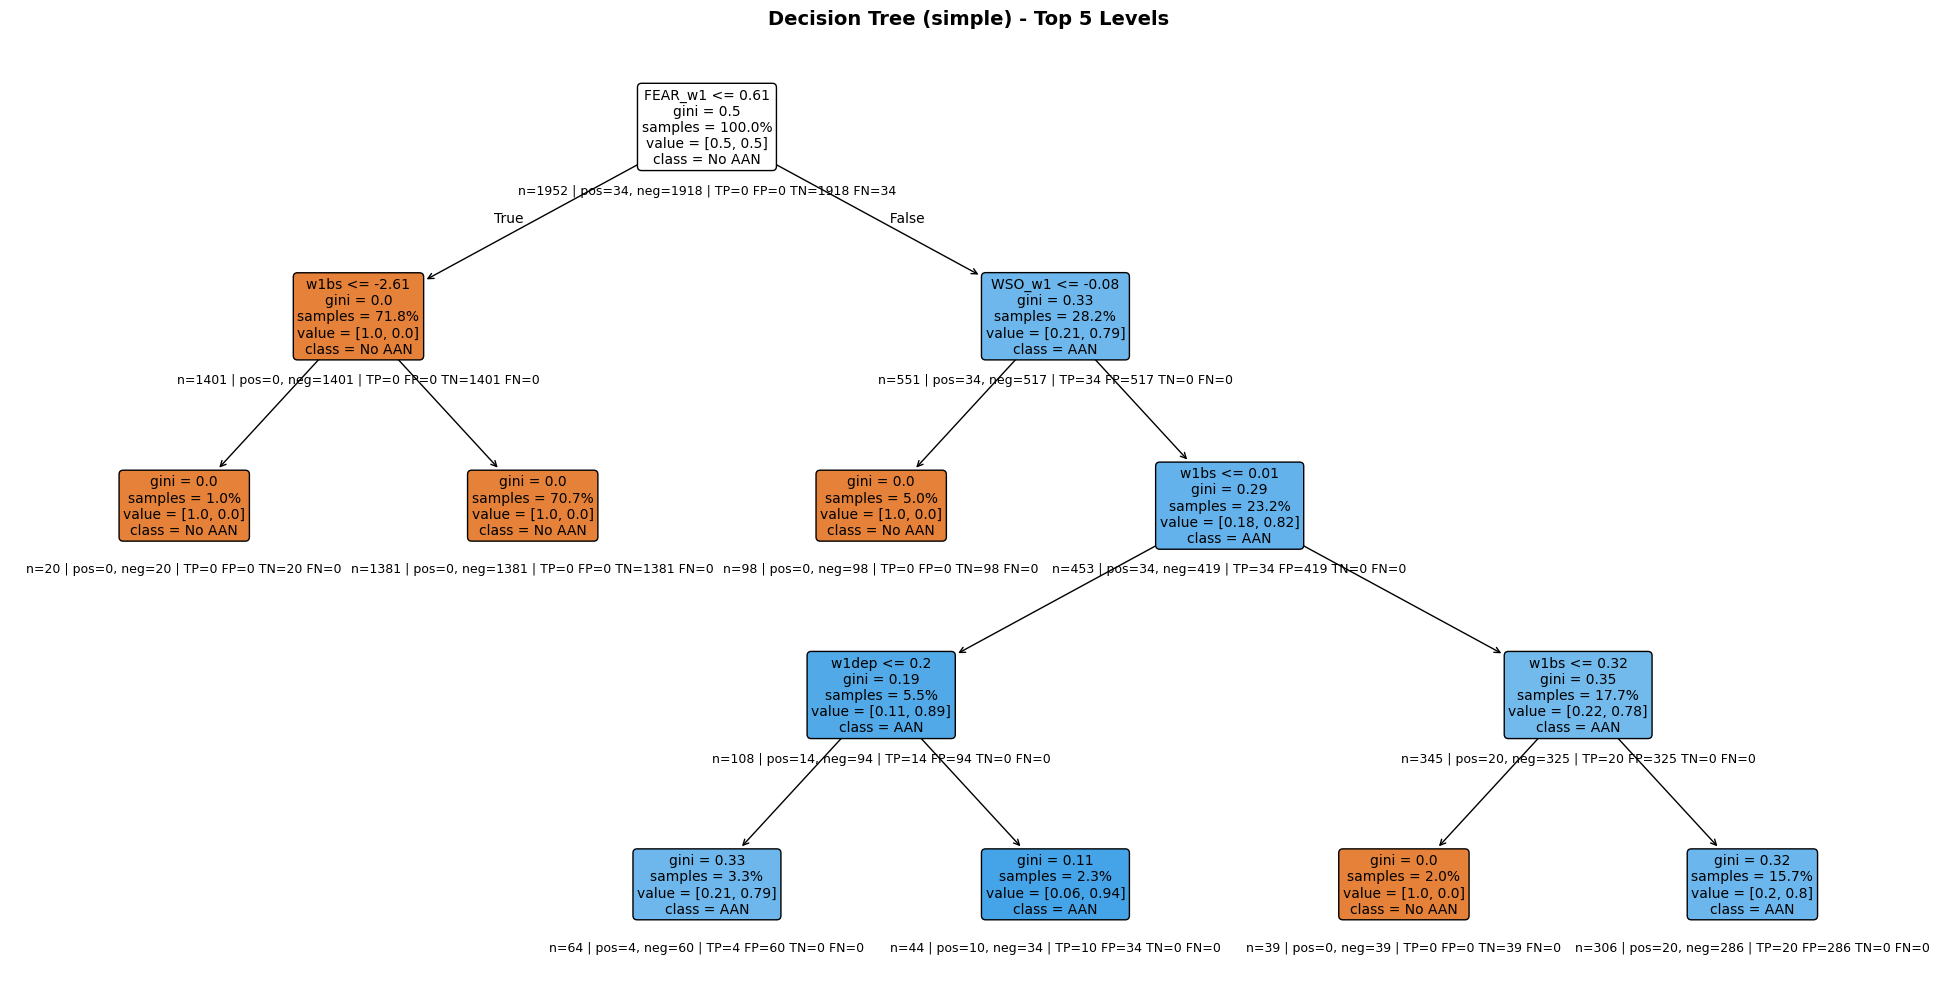

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.text import Annotation
from sklearn.tree import plot_tree

def overlay_node_counts_from_dataset(pipeline, X, y, FEATURES, best_strategy, max_depth=5,
                                     show_pr=False, ax=None):
    """
    Overlay per-node counts (n, pos, neg) and optional precision/recall on a plot_tree figure,
    computed directly from (X, y) passed in. Works with a Pipeline(imputer, scaler, clf).
    """
    clf = pipeline.named_steps['clf']
    preproc = pipeline[:-1]

    # Transform X through imputer+scaler to match what the tree uses
    Xt = preproc.transform(X)
    y_arr = np.asarray(y)

    # Which samples pass through which nodes
    node_indicator = clf.decision_path(Xt)        # csr [n_samples, n_nodes]
    n_nodes = clf.tree_.node_count
    node_pred_class = clf.tree_.value[:, 0, :].argmax(axis=1)

    # Compute per-node stats on the provided dataset (X, y)
    stats = []
    for node in range(n_nodes):
        mask = node_indicator[:, node].toarray().ravel().astype(bool)
        n = int(mask.sum())
        if n == 0:
            stats.append(None)
            continue
        pos = int((y_arr[mask] == 1).sum())
        neg = n - pos

        # Hypothetical confusion if the node predicts its majority class for anything landing here
        pred = node_pred_class[node]
        if pred == 1:
            tp, fp, tn, fn = pos, neg, 0, 0
        else:
            tn, fn, tp, fp = neg, pos, 0, 0

        s = {
            "n": n, "pos": pos, "neg": neg,
            "tp": tp, "fp": fp, "tn": tn, "fn": fn,
            "pos_rate": pos / n if n else 0.0
        }
        if show_pr:
            s["precision"] = tp / (tp + fp) if (tp + fp) else 0.0
            s["recall"]    = tp / (tp + fn) if (tp + fn) else 0.0
        stats.append(s)

    # Plot tree and overlay
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 10))
    artists = plot_tree(
        clf,
        max_depth=max_depth,
        feature_names=FEATURES,
        class_names=['No AAN', 'AAN'],
        filled=True,
        proportion=True,     # built-in label uses fractions of the full set
        precision=2,
        fontsize=10,
        rounded=True,
        ax=ax
    )

    # plot_tree returns artists in pre-order corresponding to node indices.
    label_annotations = [a for a in artists if isinstance(a, Annotation) and ('gini' in a.get_text())]
    n_to_overlay = min(len(label_annotations), n_nodes)

    added = 0
    for node_id in range(n_to_overlay):
        s = stats[node_id]
        if s is None:
            continue
        ann = label_annotations[node_id]
        x, y0 = ann.get_position()

        if show_pr:
            overlay = (f"n={s['n']} | pos={s['pos']}, neg={s['neg']} | "
                       f"TP={s['tp']} FP={s['fp']} TN={s['tn']} FN={s['fn']} | "
                       f"prec={s['precision']:.2f} rec={s['recall']:.2f}")
        else:
            overlay = (f"n={s['n']} | pos={s['pos']}, neg={s['neg']} | "
                       f"TP={s['tp']} FP={s['fp']} TN={s['tn']} FN={s['fn']}")

        ax.text(
            x, y0 - 0.06, overlay,
            ha='center', va='top', fontsize=9,
            color='black', zorder=10, clip_on=False
        )
        added += 1

    if added == 0:
        print("No overlays added—nodes within max_depth may have no samples. "
              "Try increasing max_depth or check that X matches the fitted pipeline.")
    ax.set_title(f'Decision Tree ({best_strategy}) - Top {max_depth} Levels', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return ax

# --- usage (with your already-fitted final_pipeline) ---
ax = overlay_node_counts_from_dataset(
    final_pipeline, X, y, FEATURES, best_strategy,
    max_depth=5, show_pr=False
)
plt.savefig(f'{BASE_PATH}/decision_tree_viz_with_dataset_counts.png', dpi=300, bbox_inches='tight')
plt.show()


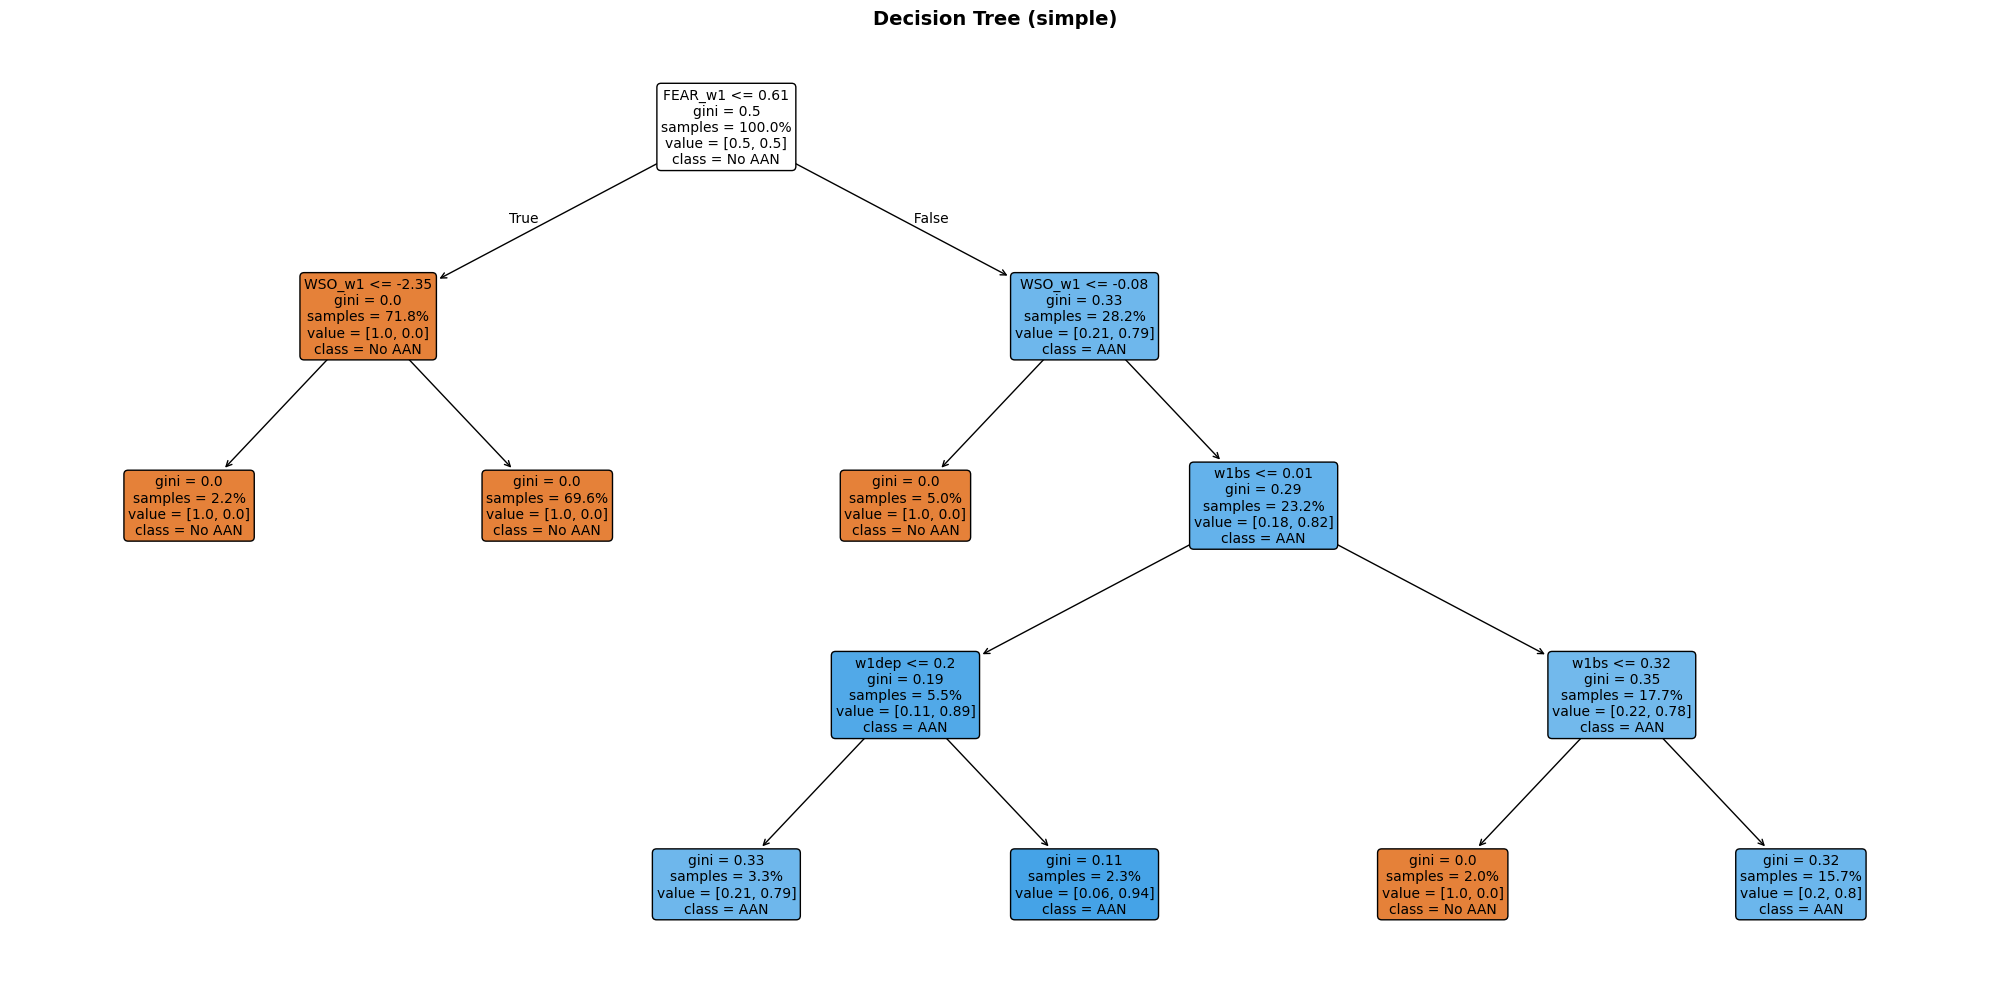

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(
    final_pipeline.named_steps['clf'],
    max_depth=6,
    feature_names=FEATURES,
    class_names=['No AAN', 'AAN'],
    filled=True,
    proportion=True,
    precision=2,
    fontsize=10,
    rounded=True
)
plt.title(f'Decision Tree ({best_strategy})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{BASE_PATH}/decision_tree_viz.png', dpi=300, bbox_inches='tight')
plt.show()


# Persistence Analysis
